In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler


In [2]:
# Collecting data on all cities
all_cities = pd.DataFrame()
for city in os.listdir('transportation_data'):
    city_name = city.split('.')[0]
    df_transport = pd.read_csv(os.path.join('transportation_data', city))
    df_transport['city'] = city_name
    all_cities = pd.concat([all_cities, df_transport], axis=0)

# Only with public transport data
has_pt = all_cities['shortest_travels'].notnull() 
all_cities_pt = all_cities[has_pt].copy()


In [3]:
all_cities_pt['fastest_arrivals'] = 60 * 60 * all_cities_pt.line_distance / all_cities_pt.fastest_arrivals
all_cities_pt['shortest_travels'] = 60 * 60 * all_cities_pt.line_distance / all_cities_pt.shortest_travels
all_cities_pt['walk_time'] = 60 * 60 * all_cities_pt.line_distance / all_cities_pt.walk_time
all_cities_pt['bike_time'] = 60 * 60 * all_cities_pt.line_distance / all_cities_pt.bike_time
all_cities_pt['car_time'] = 60 * 60 * all_cities_pt.line_distance / all_cities_pt.car_time


In [4]:
all_cities_pt

,walk_time,bike_time,car_time,line_distance,city,start_points,end_points,time,fastest_arrivals,shortest_travels,walk_distances,num_of_changes
0,4.049427,10.621399,32.207831,12.167403,pl003c1,"50.07808,19.88949","50.01353,20.02708",8:45,2.431184,4.049427,13400.85,inf
1,4.032392,11.439604,39.406620,11.789147,pl003c1,"50.04417,19.93882","50.0302,20.10245",9:02,2.394411,4.032392,12971.73,inf
2,3.807997,9.468886,38.245100,12.249056,pl003c1,"50.03751,19.96209","49.97791,20.10624",8:28,2.348062,3.807997,14118.87,inf
3,2.187738,6.090053,22.492097,5.091961,pl003c1,"50.06831,20.1005","50.10214,20.0524",6:34,1.176652,2.187738,10370.67,inf
4,3.693201,10.185106,21.508591,8.071696,pl003c1,"50.08216,19.94671","50.01933,19.89009",8:38,1.928465,3.693201,9724.81,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.601397,10.666651,24.121177,2.948144,es002k2,"41.48842,2.29811","41.50537,2.27089",7:41,1.621096,3.601397,3797.89,inf
996,2.767031,9.590028,19.395908,1.675591,es002k2,"41.50167,2.27255","41.49479,2.29045",7:02,1.043621,2.767031,2806.03,inf
997,2.986424,9.533907,18.674393,3.771190,es002k2,"41.51022,2.28482","41.47726,2.27415",8:11,1.666620,2.986424,5844.14,inf
998,2.341587,7.489479,13.828093,1.624801,es002k2,"41.49781,2.27645","41.48642,2.28867",6:35,0.603143,2.341587,3114.06,inf


In [5]:
# Collecting data on the survey
df = pd.read_stata('2023_QoL in European Cities_microdata.dta')
city_code_mapping_df = df[['Country_sample', 'D3_Cityrecode', 'City_Eurostat']].drop_duplicates()

survey_cols = [
    'D3_Cityrecode',   # this is the key we will use to merge
    'Q1a_1',           # Satisfaction with public transport
    'Q2_1',            # I am satisfied to live in my city
    'Q5_1',            # Most common mode of transport (1=car,2=motorcycle,3=bicycle,4=foot,5=train,6=urban PT)
    'Q5_2',            # Second most common mode (same coding)
    'Q6_3',            # Transport is easy to get (Strongly disagree → Strongly agree)
    'Q6_4',            # Transport is frequent
    'Q6_5',            # Transport is reliable
]

mapping_sat = {
    'Very dissatisfied': 0,
    'Very unsatisfied': 0,
    'Dissatisfied': 1,
    'Rather unsatisfied': 1,
    'Neutral': 2,
    'Satisfied': 3,
    'Rather satisfied': 3,
    'Very satisfied': 4
}

mapping_agree = {
    'Strongly disagree': 0,
    'Somewhat disagree': 1, 
    'Somewhat agree': 3,
    'Strongly agree': 4
}

df_survey = df[survey_cols].copy()

In [6]:
# Convert to numerical 
df_survey['Q1a_1_num'] = df_survey['Q1a_1'].map(mapping_sat)
df_survey['Q2_1_num'] = df_survey['Q2_1'].map(mapping_agree)
df_survey['Q6_3_num'] = df_survey['Q6_3'].map(mapping_agree)
df_survey['Q6_4_num'] = df_survey['Q6_4'].map(mapping_agree)
df_survey['Q6_5_num'] = df_survey['Q6_5'].map(mapping_agree)

# Creating city-level averages for numerical satisfaction and agreement scores
df_survey_numerical = df_survey[['D3_Cityrecode', 'Q1a_1_num', 'Q2_1_num', 'Q6_3_num', 'Q6_4_num', 'Q6_5_num']].copy()
df_survey_numerical_grouped = df_survey_numerical.groupby('D3_Cityrecode',observed=False).mean().reset_index().rename(columns={
        'Q1a_1_num': 'avg_PT_satisfaction',
        'Q2_1_num': 'avg_Life_satisfaction',
        'Q6_3_num': 'avg_EasyToGet',
        'Q6_4_num': 'avg_Frequent',
        'Q6_5_num': 'avg_Reliable'
    })

# Basically calculating the percentage of each mode of transport used as primary mode
df_survey_modes = df_survey[['D3_Cityrecode', 'Q5_1', 'Q5_2']].copy()
mode_dummies = pd.get_dummies(df_survey_modes['Q5_1'], prefix='mode1')
df_modes = pd.concat([df_survey[['D3_Cityrecode']], mode_dummies], axis=1)

mode_prop = (
    df_modes
    .groupby('D3_Cityrecode', observed=False)
    .mean()
    .reset_index()
)

mode_prop = mode_prop.rename(columns={
    'mode1_Car': 'pct_primary_car',
    'mode1_Motorcycle': 'pct_primary_motorcycle',
    'mode1_Bicycle': 'pct_primary_bicycle',
    'mode1_Foot': 'pct_primary_foot',
    'mode1_Train': 'pct_primary_train',
    'mode1_Urban public transport (bus, tram or metro)': 'pct_primary_urbanPT'
})
mode_prop = mode_prop[['D3_Cityrecode',
                       'pct_primary_car', 
                       'pct_primary_motorcycle', 
                       'pct_primary_bicycle', 
                       'pct_primary_foot', 
                       'pct_primary_train', 
                       'pct_primary_urbanPT']]

# Merging the city code mapping with the survey results
df_survey_final = df_survey_numerical_grouped.join(
    mode_prop.set_index('D3_Cityrecode'), 
    on='D3_Cityrecode', 
    how='left'
)

In [7]:
# Gathered data on all cities
numeric_cols = ['walk_time','bike_time','car_time','line_distance','fastest_arrivals','shortest_travels','walk_distances']

all_cities_pt_grouped = (
    all_cities_pt
    .groupby('city')[numeric_cols]
    .mean()
    .rename(columns={
        'fastest_arrivals':'PT_fastest_arr',
        'shortest_travels':'PT_shortest_time'
    })
    .reset_index()
)
all_cities_pt_grouped['city'] = all_cities_pt_grouped['city'].str.upper()

per_city_metrics = all_cities_pt_grouped.join(
    city_code_mapping_df.set_index('City_Eurostat'),
    on='city',
    how='left'
)

per_city_metrics = per_city_metrics[['Country_sample', 'city', 'D3_Cityrecode',] + list(all_cities_pt_grouped.columns.drop('city'))]
per_city_metrics.loc[per_city_metrics['city'].isin(['CH001K1', 'CH002K1']), 'Country_sample'] = 'Switzerland'
per_city_metrics.loc[per_city_metrics['city'] == 'CH001K1', 'D3_Cityrecode'] = 'Zürich'
per_city_metrics.loc[per_city_metrics['city'] == 'CH002K1', 'D3_Cityrecode'] = 'Genève'
merged_df = pd.merge(per_city_metrics, df_survey_final, on="D3_Cityrecode", how="inner")

cities_subset = per_city_metrics['D3_Cityrecode'].unique()
df_survey_final = df_survey_final[df_survey_final['D3_Cityrecode'].isin(cities_subset)]

In [8]:
per_city_metrics.head(4)

,Country_sample,city,D3_Cityrecode,walk_time,bike_time,car_time,line_distance,PT_fastest_arr,PT_shortest_time,walk_distances
0,Austria,AT001C1,Wien,3.624934,10.061277,26.118816,9.130615,2.173641,3.624934,11230.100541
1,Belgium,BE001C1,Bruxelles / Brussel,3.377355,8.306606,15.874620,1.699583,0.658129,3.377355,2235.286236
2,Belgium,BE002C1,Antwerpen,3.438648,10.528180,30.284676,8.228123,1.911409,3.438648,11076.802240
3,Belgium,BE005C1,Liège,3.642075,12.159893,25.987394,3.521213,1.265460,3.642075,4502.677357


In [9]:
df_survey_final.head(4)

,D3_Cityrecode,avg_PT_satisfaction,avg_Life_satisfaction,avg_EasyToGet,avg_Frequent,avg_Reliable,pct_primary_car,pct_primary_motorcycle,pct_primary_bicycle,pct_primary_foot,pct_primary_train,pct_primary_urbanPT
1,Wien,3.445867,3.410256,3.354726,2.919144,3.166861,0.356069,0.045087,0.116763,0.217341,0.028902,0.220809
2,Antwerpen,2.561812,3.396471,2.979394,2.428919,2.390791,0.486486,0.050529,0.182139,0.144536,0.019976,0.104583
3,Bruxelles / Brussel,2.699147,3.073770,3.221557,2.829504,2.671894,0.492974,0.057377,0.079625,0.138173,0.030445,0.185012
4,Liège,2.247754,3.111765,3.052821,2.830325,2.448655,0.600939,0.057512,0.038732,0.129108,0.015258,0.142019


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from scipy import stats
import matplotlib.pyplot as plt

def create_pt_attractiveness_score(merged_df):
    """
    Create PT attractiveness score with exact same implementation
    """
    # Create required component metrics
    merged_df['PT_vs_bike_time'] = merged_df['PT_shortest_time'] / merged_df['bike_time']
    merged_df['PT_vs_walk_time'] = merged_df['PT_shortest_time'] / merged_df['walk_time'] 
    merged_df['access_burden'] = merged_df['walk_distances'] / merged_df['line_distance']
    
    # Create PT attractiveness score (exactly as in original)
    scaler = RobustScaler()
    components = {}
    
    # Speed competitiveness (lower ratio = faster PT relative to bike)
    if 'PT_vs_bike_time' in merged_df.columns:
        components['speed_vs_bike'] = -scaler.fit_transform(merged_df[['PT_vs_bike_time']]).flatten()
    
    if 'access_burden' in merged_df.columns:
        components['access_convenience'] = scaler.fit_transform(merged_df[['access_burden']]).flatten()

    if 'PT_vs_walk_time' in merged_df.columns:
        components['PT_vs_walk_time'] = -scaler.fit_transform(merged_df[['PT_vs_walk_time']]).flatten()
    
    # Create composite attractiveness score
    if components:
        merged_df['PT_attractiveness_score'] = np.mean(list(components.values()), axis=0)
    
    return merged_df

def analyze_pt_attractiveness_correlation(merged_df):
    """
    Analyze correlation between PT attractiveness score and satisfaction
    """
    satisfaction_col = 'avg_PT_satisfaction'
    metric = 'PT_attractiveness_score'
    
    # Clean data for correlation analysis
    clean_data = merged_df[[metric, satisfaction_col]].dropna()
    
    if len(clean_data) > 5:
        pearson_r, pearson_p = stats.pearsonr(clean_data[metric], clean_data[satisfaction_col])
        
        print("PT Attractiveness Score Analysis:")
        print("-" * 40)
        print(f"Correlation with PT Satisfaction: r = {pearson_r:.3f}")
        print(f"P-value: {pearson_p:.6f}")
        print(f"Number of observations: {len(clean_data)}")
        
        significance = "***" if pearson_p < 0.001 else "**" if pearson_p < 0.01 else "*" if pearson_p < 0.05 else "ns"
        print(f"Significance: {significance}")
        
        return pearson_r, pearson_p, len(clean_data)
    else:
        print("Not enough data points for correlation analysis")
        return None, None, 0

def plot_pt_attractiveness(merged_df):
    """
    Create visualization of PT attractiveness score vs satisfaction
    """
    x = merged_df['PT_attractiveness_score']
    y = merged_df['avg_PT_satisfaction']
    mask = ~(np.isnan(x) | np.isnan(y))
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x[mask], y[mask], alpha=0.6)
    
    # Add correlation info to plot
    clean_data = merged_df[['PT_attractiveness_score', 'avg_PT_satisfaction']].dropna()
    if len(clean_data) > 5:
        r_val, _ = stats.pearsonr(clean_data['PT_attractiveness_score'], clean_data['avg_PT_satisfaction'])
        plt.title(f'PT Attractiveness Score vs Satisfaction (r = {r_val:.3f})')
    
    plt.xlabel('PT Attractiveness Score')
    plt.ylabel('PT Satisfaction')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def run_pt_attractiveness_analysis(merged_df):
    """
    Run the complete PT attractiveness analysis
    """
    print("PT Attractiveness Score Analysis")
    print("=" * 40)
    
    # Create PT attractiveness score
    enhanced_df = create_pt_attractiveness_score(merged_df)
    
    # Analyze correlation
    correlation_results = analyze_pt_attractiveness_correlation(enhanced_df)
    
    # Create visualization
    plot_pt_attractiveness(enhanced_df)
    
    return enhanced_df, correlation_results

In [19]:
# enhanced_df, correlations = run_analysis(merged_df)


PT Attractiveness Score Analysis
PT Attractiveness Score Analysis:
----------------------------------------
Correlation with PT Satisfaction: r = -0.496
P-value: 0.000086
Number of observations: 57
Significance: ***


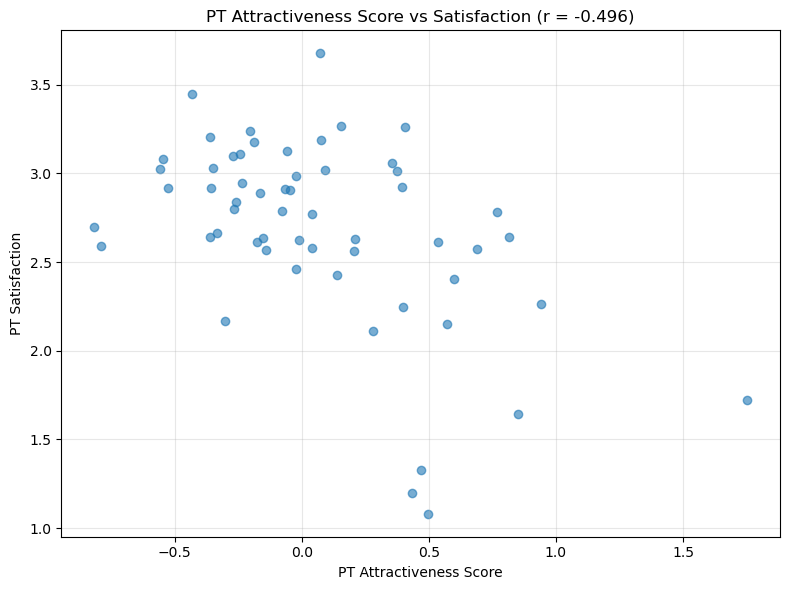

In [20]:
enhanced_df, correlations = run_pt_attractiveness_analysis(merged_df)
